# Load libraries and set figures parameters

In [1]:
%matplotlib inline
import re
import gensim
import nltk
import joblib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gensim.corpora as corpora

from gensim.utils import simple_preprocess
from gensim.models import ldamulticore
from gensim.test.utils import datapath
from gensim.models import Phrases
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
sns.set()
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')

# Import dataset and sub-sampling

In [3]:
data_stackoverflow = pd.read_csv('QueryResults_for_test.csv', low_memory=False)
print(f'data_test_shape: {data_stackoverflow.shape}')

data_test_shape: (50000, 10)


- Analyze the ViewCount and choose a threshold 

Minimun View: 2
Maximun View: 16856
Median of View: 27.0


(0.0, 1500.0)

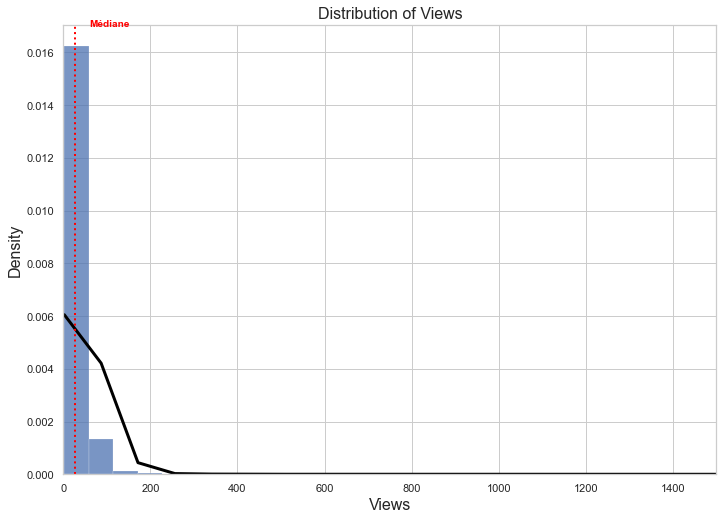

In [4]:
# Views min, max and median
print(f'Minimun View: {data_stackoverflow.ViewCount.min()}')
print(f'Maximun View: {data_stackoverflow.ViewCount.max()}')
print(f'Median of View: {data_stackoverflow.ViewCount.median()}')

# Figure
q = sns.histplot(x=data_stackoverflow['ViewCount'], bins=300, stat = "density")
ax= sns.kdeplot(x=data_stackoverflow['ViewCount'], bw_adjust=5, cut=0, color = "black", lw=3)

q.text(60, 0.017, "Médiane", horizontalalignment='left', size=10, color='red', weight='semibold')
q.axvline(x=data_stackoverflow['ViewCount'].median(), color = 'red', lw=2, linestyle='dotted')
q.set_title('Distribution of Views', fontsize=16)
q.set_xlabel ('Views', fontsize=16)
q.set_ylabel ('Density', fontsize=16)
q.set_xlim(0, 1500)
        # The thershold will be fixed at 50

- Data sampling

In [5]:
# Select Views > 50
data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=50]

# Random sampling of 30 rows and keeping the columns 'Title' and 'Tags' only.
df_sample = data_stackoverflow.iloc[21:5000,[-6, -5]].sample(n=30).reset_index().drop(['index'], axis=1)
df_sample

,Title,Tags
0,Lambda RDS Proxy connection from different VPC,<amazon-web-services><aws-lambda><amazon-rds><...
1,Can't locate this input element selenium,<python-3.x><selenium>
2,PHP output not sliceable by Javascript,<javascript><php><jquery><ajax>
3,How do I fill a new array with n distinct empt...,<javascript><arrays><expression><fill><one-liner>
4,Change an existing field of value type float t...,<go><protocol-buffers>
5,EF Core Linq-to-Sql GroupBy SelectMany not wor...,<c#><sql-server><entity-framework-core>
6,How do MySQL aggregate sum function with two d...,<mysql><sum><aggregate>
7,How to do a join from 2 JSON by a common ID fi...,<javascript><arrays>
8,Angular circular dependency: best practices fo...,<javascript><angular><typescript><circular-dep...
9,ERROR: Socket /var/run/openvswitch/ovnnb_db.so...,<openstack><openstack-neutron>


# Data pre-processing and cleaning

In [6]:
# Remove punctuation from both columns 'Title' and 'Tags'
df_sample['Title_processed'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]', ' ', x))
df_sample['Tags_StackOverFlow'] = df_sample['Tags'].map(lambda x: re.sub('[,\.!?<>-]', ' ', x))

# The rest of the data pre-processing will be applied only to the column "Title"

def extract_NN(sent):
    grammar = r"""
    
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'
        {<NN>} # noun, singular 'desk'
        {<NNS>} # noun plural 'desks'
        {<FW>} # foreign word
                            
    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne


df_sample['Title_extracted'] = df_sample.Title.apply(extract_NN)
df_sample


# Tokenize and Lemmatize words

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_sample.Title_extracted))


def Text_preprocessor(texts):
    lemmatizer = WordNetLemmatizer() # Lemmatize all words
    texts = [[lemmatizer.lemmatize(token) for token in doc] for doc in texts]
    return texts

data_words = Text_preprocessor(data_words)


# Remove Stopwords

# Let’s define the functions to remove the stopwords.

stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# Data shaping for the analysis

Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))

# Supervised Model SGDClassifier predictions

In [7]:
# Load models

Tags_model = open('Tags_model.pkl','rb')
clf = joblib.load(Tags_model)

tfidf_model = open('tfidf_vectorizer.pkl','rb')
tfidf_vectorizer = joblib.load(tfidf_model)

mlb_model = open('mlb.pkl','rb')
mlb = joblib.load(mlb_model)

In [8]:
# Create the data on which I will do the analysis
mydata = pd.DataFrame()
mydata['Text'] = Texts


# Vectorize processed text
X_newdata = tfidf_vectorizer.transform(mydata['Text'].tolist())


# Predict tags
tags = clf.predict(X_newdata)

Tags = pd.DataFrame(tags, columns=mlb.classes_).apply(lambda row: row[row == 1].index.values.tolist(), axis=1)


# Add the predicted Tags to the df
df_sample['Tags_from_supervised_model'] = Tags

# Unsupervised LDA model predictions

In [9]:
# Load models
temp_file = datapath("final_model")
lda = gensim.models.LdaMulticore.load(temp_file)

In [10]:
# Phrase Modeling: Bigram and Trigram Models

# Bigrams/Trigrams
#=================
 # Add bigrams (if appears 10 times or more)
bigram = Phrases(data_words_nostops, min_count=10, threshold=100) # min_count: Ignore all words and bigrams with total 
                                                                  #            collected count lower than this value.
                                                                  # Threshold: Represent a score threshold for forming 
                                                                  #            the phrases (higher means fewer phrases). 

# Add trigrams (if appears 10 times or more)
trigram = Phrases(bigram[data_words_nostops], min_count=10, threshold=100) 

for idx in range(len(data_words_nostops)):
    for token in bigram[data_words_nostops[idx]]:
        if '_' in token:
            data_words_nostops[idx].append(token)  
    # Token is a bigram, add to document        
    for token in trigram[data_words_nostops[idx]]:
        if '_' in token:
            # Token is a trigram, add to document
            data_words_nostops[idx].append(token)

            
# Data Transformation: Corpus and Dictionary
# Create Dictionary
id2word_new = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus_new = [id2word_new.doc2bow(text) for text in texts]

# Fit the model by incrementally training on the new corpus.
lda.update(corpus_new)  # update the LDA model with additional documents

In [11]:
# Select the two most dominant topics

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df1 = pd.DataFrame()
    sent_topics_df2 = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df1 = sent_topics_df1.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j==1:
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df2 = sent_topics_df2.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            
            else:
                break    
             
    sent_topics_df = sent_topics_df1.join(sent_topics_df2, lsuffix='_First_topic', rsuffix='_Second_topic')
    
    # Add the text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Apply format_topics_sentences on my lda model
df_dominant_topic_new = format_topics_sentences(ldamodel=lda, corpus=corpus_new, texts=data_words_nostops)

# Format
df_dominant_topic_new.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
                                 'Sec_Dominant_Topic', 'Sec_Perc_Contribution', 'Sec_Topic_Keywords', 'Text']

In [12]:
# Search the common words bewteen the dominant topic and the Text
Keywords1_Text = []

for i in range(0, len(df_dominant_topic_new)):
    Keywords1 = df_dominant_topic_new['Topic_Keywords'][i]
    Text = df_dominant_topic_new['Text'][i]
    Keywords1_Text.append([x for x in Keywords1 if x in Text])
df_dominant_topic_new['Keywords1_Text'] = Keywords1_Text # Add the common words to the df_dominant_topic_news


# Search the common words bewteen the second dominant topic and the Text if the contribution > 1
Keywords2_Text = []

for i in range(0, len(df_dominant_topic_new)):
    
    if df_dominant_topic_new['Sec_Perc_Contribution'][i]>0.1:
        Keywords2 = df_dominant_topic_new['Sec_Topic_Keywords'][i]
        Text = df_dominant_topic_new['Text'][i]
        Keywords2_Text.append([x for x in Keywords2 if x in Text])
        
    elif df_dominant_topic_new['Sec_Perc_Contribution'][i]<=0.1 :
        Keywords2_Text.append([])
df_dominant_topic_new['Keywords2_Text'] = Keywords2_Text # Add the common words to the df_dominant_topic_news


# Search the common words between topic 1 and 2
common_word = []

for i in range(0,len(df_dominant_topic_new)):
    
    if df_dominant_topic_new['Sec_Perc_Contribution'][i]>0.1:
        Keywords1 = df_dominant_topic_new['Topic_Keywords'][i]
        Keywords2 = df_dominant_topic_new['Sec_Topic_Keywords'][i]
        common_word.append([x for x in Keywords1 if x in Keywords2][:3])

    elif df_dominant_topic_new['Sec_Perc_Contribution'][i]<=0.1 :
        common_word.append([])
df_dominant_topic_new['Common_Word'] = common_word # Add the common words to the df_dominant_topic_news


df_dominant_topic_new['Tags'] = (df_dominant_topic_new['Keywords1_Text'] + 
                             df_dominant_topic_new['Keywords2_Text'] + 
                             df_dominant_topic_new['Common_Word'])

new_liste = []
for i in range(0,len(df_dominant_topic_new)):
    mylist = df_dominant_topic_new['Tags'][i]
    newlist = sorted(set(mylist), key=lambda x:mylist.index(x))
    new_liste.append(newlist)

# Add the predicted Tags to the df
df_sample['Tags_from_unsupervised_LDA'] = new_liste

# NMF

In [13]:
# load the models
nmf_ = open('nmf_model.pkl','rb')
nmf = joblib.load(nmf_)

nmf_tfidf = open('nmf_tfidf.pkl','rb')
tfidf = joblib.load(nmf_tfidf)

In [14]:
# Calculate tfidf on new data
df_sample['processed_text'] = data_words_nostops
df_sample.head()

new_documents = []
for i in df_sample['processed_text']:
    new_documents.append(' '.join(map(str, i)))
    
tfidf_new = tfidf.transform(new_documents)
tfidf_new_feature_names = tfidf.get_feature_names()


# Fit nmf on the new data
X_new = nmf.transform(tfidf_new)


# Get the two dominant predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new] # dominant text
predicted_topics_2 = [np.argsort(each)[::-1][1] for each in X_new] # second dominant text
# Add to df
df_sample['pred_topic_num'] = predicted_topics
df_sample['pred_topic_num2'] = predicted_topics_2


# Display the first most frequent words of each topic
words_of_topic = []

def display_topics(model, feature_names, no_top_words):# define a function that allow to display the most frequent words in each topic 
    for topic_idx, topic in enumerate(model.components_):
        words_of_topic.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

no_top_words = 100
display_topics(nmf, tfidf_new_feature_names, no_top_words)

words_topic1 = []
for i in df_sample.loc[:, 'pred_topic_num']:
    words_topic1.append(words_of_topic[i])

words_topic2 = []
for i in df_sample.loc[:, 'pred_topic_num2']:
    words_topic2.append(words_of_topic[i])
# Add to df  
df_sample['pred_topic_words'] = words_topic1
df_sample['pred_topic_words2'] = words_topic2

In [15]:
# Search the common words bewteen the dominant topic and the Text
Keywords1_Text = []

for i in range(0, len(df_sample)):
    Keywords1 = df_sample['pred_topic_words'][i]
    Text = df_sample['processed_text'][i]
    Keywords1_Text.append([x for x in Keywords1 if x in Text])
df_sample['Keywords1_Text'] = Keywords1_Text # Add the common words to the df_dominant_topic_news


# Search the common words bewteen the second dominant topic and the Text
Keywords2_Text = []

for i in range(0, len(df_sample)):
    Keywords2 = df_sample['pred_topic_words2'][i]
    Text = df_sample['processed_text'][i]
    Keywords2_Text.append([x for x in Keywords2 if x in Text])
df_sample['Keywords2_Text'] = Keywords2_Text # Add the common words to the df_dominant_topic_news

# Search the common words between topic 1 and 2
common_word = []

for i in range(0,len(df_sample)):
    
    Keywords1 = df_sample['pred_topic_words'][i]
    Keywords2 = df_sample['pred_topic_words2'][i]
    common_word.append([x for x in Keywords1 if x in Keywords2][:2])

df_sample['Common_Word'] = common_word # Add the common words to the df_dominant_topic_news


# Proposed tags
df_sample['Tags'] = (df_sample['Keywords1_Text'] + 
                             df_sample['Keywords2_Text'] + 
                             df_sample['Common_Word'])

new_liste2 = []
for i in range(0,len(df_sample)):
    mylist = df_sample['Tags'][i]
    newlist = sorted(set(mylist), key=lambda x:mylist.index(x))
    new_liste2.append(newlist)

df_sample['Tags_from_unsupervised_NMF'] = new_liste2

# Results of the predicted Tags from all the three models

In [16]:
df_results = df_sample.iloc[:,[0, 3, 5, 6, -1]]
df_results

,Title,Tags_StackOverFlow,Tags_from_supervised_model,Tags_from_unsupervised_LDA,Tags_from_unsupervised_NMF
0,Lambda RDS Proxy connection from different VPC,amazon web services aws lambda amazon rds ...,[],[connection],"[lambda, eks, ec]"
1,Can't locate this input element selenium,python 3 x selenium,"[python, selenium]","[azure, service, app]","[element, input, eks, ec]"
2,PHP output not sliceable by Javascript,javascript php jquery ajax,"[javascript, php]",[php],"[javascript, error, url]"
3,How do I fill a new array with n distinct empt...,javascript arrays expression fill one liner,[array],[],"[eks, ec]"
4,Change an existing field of value type float t...,go protocol buffers,[],[],"[float, message, eks, ec]"
5,EF Core Linq-to-Sql GroupBy SelectMany not wor...,c# sql server entity framework core,"[core, entity, framework, net, server, sql]","[sql, function, pas, customized]","[sql, server, linq, ef, access, insert]"
6,How do MySQL aggregate sum function with two d...,mysql sum aggregate,[mysql],[],"[function, table, mysql, run]"
7,How to do a join from 2 JSON by a common ID fi...,javascript arrays,[javascript],[],"[json, javascript, html, array]"
8,Angular circular dependency: best practices fo...,javascript angular typescript circular dep...,[],[],"[eks, ec]"
9,ERROR: Socket /var/run/openvswitch/ovnnb_db.so...,openstack openstack neutron,[],[],"[run, error, function]"


In [17]:
# Save the data in csv file
pd.DataFrame(df_results).to_csv('test_results.csv', index=False)

- Visually analyzing the table, we can see that the model that proposes the most relevant tags and sometimes the same as those already present in Stackoverflow is SGDClassifier.

- If the question has little informative elements for the model, the supervised method (SDClassifier) returns empty predictions. However, unsupervised approaches, especially NMF, tend to return tags that are not relevant to the question instead of proposing nothing.

- Finally the ease of implementation and the overall prediction performance of the SGDClassifier, I choose to deploy the supervised model only.